In [1]:
import pandas as pd

# Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

#Calculating libraries
from scipy.stats import bootstrap
import numpy as np
from scipy import stats
import scipy as sp
import matplotlib.dates as md

#statistical librairies
from os import stat

# Others
from functools import partial
from ast import literal_eval

In [12]:
character=pd.read_table('./data/character.metadata.tsv',header=None)
movies=pd.read_table('./data/movie.metadata.tsv',header=None)
names=pd.read_csv('./data/name.clusters.txt',sep="\t",header=None)
summaries=pd.read_csv('./data/plot_summaries.txt',sep="\t",header=None)
tvtropes=pd.read_csv('./data/tvtropes.clusters.txt',sep="\t",header=None)
ratings = pd.read_csv('./data/title.ratings.tsv', sep = "\t")
titles = pd.read_csv('./data/title.basics.tsv', sep = "\t")

/tmp/ipykernel_197761/1466212048.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv('./data/title.basics.tsv', sep = "\t")


In [13]:
character=character.rename(columns={0:'wikipedia_movie_id',1:'Freebase_movie_ID',3:'character_name',4:'Actor_DOB',5:'Actor_gender',6:'actor_height',7:'Actor_etnicity',8:'Actor_name',9:'Actor_age_at_movie_release',10:'Freebase_character_map'})
movies.rename(columns={0:'wikipedia_movie_id',1:'Freebase_movie_ID',2:'Movie_name',3:'Movie_release',4:'Box_office_revenue',5:'Movie_runtime',6:'Movie_language',7:'Movie_country',8:'Movie_genre'},inplace=True)
names.rename(columns={0:'Character_names',1:'Freebase_ID'},inplace=True)
tvtropes.rename(columns={0:'Character_type',1:'Freebase_ID'},inplace=True)
summaries.rename(columns={0:'wikipedia_movie_id',1:'Plot_summaries'},inplace=True)

In [14]:
tvtropes["dict_ID"]=[literal_eval(i) for i in tvtropes.Freebase_ID]
tvtropes=pd.concat([tvtropes.drop(['dict_ID'], axis=1), tvtropes
                    ['dict_ID'].apply(pd.Series)], axis=1)

In [15]:
titles = pd.merge(titles, ratings, on = 'tconst')
titles = titles[['primaryTitle','originalTitle','averageRating', 'startYear']]
titles['Movie_release_year'] = pd.to_datetime(titles['startYear'], errors = 'coerce').dt.year
movies['Movie_release_year'] = pd.to_datetime(movies['Movie_release'], errors= 'coerce').dt.year
titles = titles.rename(columns = {'primaryTitle': 'Movie_name'})
titles = titles.groupby('Movie_name').mean()
titles.reset_index(inplace = True)
movies = pd.merge(movies, titles, on = ['Movie_name', 'Movie_release_year']).drop(['Movie_release_year'], axis = 1)

In [5]:
columns_with_null = list(character.isna().sum().loc[lambda x: x>0].index)
print ("\nhere are the character features with null values:")
for column in columns_with_null:
    print(column)

columns_with_null = list(movies.isna().sum().loc[lambda x: x>0].index)
print ("\nhere are the movie features with null values:")
for column in columns_with_null:
    print(column)

columns_with_null = list(names.isna().sum().loc[lambda x: x>0].index)
print ("\nhere are the name features with null values:")
for column in columns_with_null:
    print(column)

columns_with_null = list(tvtropes.isna().sum().loc[lambda x: x>0].index)
print ("\nhere are the tvtropes features with null values:")
for column in columns_with_null:
    print(column)

columns_with_null = list(summaries.isna().sum().loc[lambda x: x>0].index)
print ("\nhere are the summaries features with null values:")
for column in columns_with_null:
    print(column)


here are the character features with null values:
2
character_name
Actor_DOB
Actor_gender
actor_height
Actor_etnicity
Actor_name
Actor_age_at_movie_release
11
12

here are the movie features with null values:
Movie_release
Box_office_revenue
Movie_runtime

here are the name features with null values:

here are the tvtropes features with null values:

here are the summaries features with null values:


In [39]:
import json

from collections import defaultdict

movies['Movie_release'] = pd.to_datetime(movies['Movie_release'], errors = 'coerce')
sorted_movies = movies.sort_values("Movie_release", ascending=False).dropna(subset=['Movie_release'])

genres_per_year = sorted_movies[['Movie_release', 'Movie_name', 'Movie_genre']]
genres_per_year['Movie_genre'] = genres_per_year.Movie_genre.apply(json.loads).apply(lambda x: list(x.values()))

occur = genres_per_year.copy()

occur.head(20)

C:\Users\nicte\AppData\Local\Temp/ipykernel_17096/184808861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_per_year['Movie_genre'] = genres_per_year.Movie_genre.apply(json.loads).apply(lambda x: list(x.values()))


,Movie_release,Movie_name,Movie_genre
34022,2016-06-08,Jeepers Creepers 4,"[Thriller, Horror]"
30275,2016-03-18,Kung Fu Panda 3,[]
64862,2016-01-01,Battle Angel,"[Thriller, Science Fiction, Action, Romance Film]"
53855,2015-01-01,Total Dhamaal,[Comedy film]
8307,2015-01-01,"I, Robot 2",[Science Fiction]
40166,2015-01-01,Knight Rider: The Movie,"[Crime Fiction, Science Fiction, Action]"
51429,2015-01-01,Avatar 2,"[Science Fiction, Action, Fantasy, Adventure]"
70420,2014-12-30,Hosa Prema Purana,[Romance Film]
34454,2014-08-15,Appayya,[Romance Film]
52234,2014-07-01,Bulbul,[]


In [9]:
from utils.genres import genre_wordsets

def extract_genres(all_genres:object)->list:
    """ returns 1 if one pronoun in pronouns is in headline else 0

    Args:
        pronouns (list): list of pronouns
        headline (object): headline of the article

    Returns:
        list: 1 if there is a pronoun from pronouns in headline else 0 
    """
    genre_list = []
    genres = all_genres.copy()

    if 'Black-and-white' in all_genres:
        genre_list.append("Black & White")
        genres.remove("Black-and-white")
    
    if 'Science Fiction' in all_genres:
        genre_list.append("Science Fiction")
        genres.remove("Science Fiction")

    genre_string = " ".join([str(g) for g in genres]).lower()

    genre_string = genre_string.replace('/', ' ')
    genre_string = genre_string.replace('-', ' ')

    
    for m_genres, sub_genres in genre_wordsets.items() : 
        for s_g in sub_genres :
            if s_g in genre_string.split(" "):
                genre_list.append(m_genres)
    
    if len(genre_list) == 0 :
        genre_list.append("Other")

    genre_list = list(set(genre_list))

    return genre_list

In [10]:
genres_per_year["Major_genres"]=genres_per_year["Movie_genre"].apply(
    partial(extract_genres))

C:\Users\nicte\AppData\Local\Temp/ipykernel_17096/544170449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres_per_year["Major_genres"]=genres_per_year["Movie_genre"].apply(


In [11]:
genres_per_year = genres_per_year.explode('Major_genres')
occur = occur.explode('Movie_genre')

In [12]:
occur_major = genres_per_year.copy()

time_genres = occur.groupby(pd.PeriodIndex(occur['Movie_release'], freq="Y"))['Movie_genre'].value_counts().reset_index(name='Genres_per_year')

f_per_year = occur.groupby(pd.PeriodIndex(occur['Movie_release'], freq="Y")).size().reset_index(name='Films_per_year')
f_per_year.index = f_per_year['Movie_release']
time_genres['Films_per_year'] = time_genres['Movie_release'].map(f_per_year['Films_per_year'])
time_genres['Genre_proportion'] = time_genres['Genres_per_year']/time_genres['Films_per_year']

time_genres.head(5)

,Movie_release,Movie_genre,Genres_per_year,Films_per_year,Genre_proportion
0,1888,Black-and-white,1,4,0.25
1,1888,Indie,1,4,0.25
2,1888,Short Film,1,4,0.25
3,1888,Silent film,1,4,0.25
4,1889,Black-and-white,1,4,0.25


In [13]:
time_genres = occur_major.groupby(pd.PeriodIndex(occur_major['Movie_release'], freq="Y"))['Major_genres'].value_counts().reset_index(name='Genres_per_year')

f_per_year = occur_major.groupby(pd.PeriodIndex(occur_major['Movie_release'], freq="Y")).size().reset_index(name='Films_per_year')
f_per_year.index = f_per_year['Movie_release']
time_genres['Films_per_year'] = time_genres['Movie_release'].map(f_per_year['Films_per_year'])
time_genres['Genre_proportion'] = time_genres['Genres_per_year']/time_genres['Films_per_year']

time_genres.head(30)

,Movie_release,Major_genres,Genres_per_year,Films_per_year,Genre_proportion
0,1888,Black & White,1,3,0.333333
1,1888,Indie,1,3,0.333333
2,1888,Silent,1,3,0.333333
3,1889,Black & White,1,3,0.333333
4,1889,Indie,1,3,0.333333
5,1889,Silent,1,3,0.333333
6,1890,Silent,2,3,0.666667
7,1890,Indie,1,3,0.333333
8,1891,Indie,3,4,0.750000
9,1891,Silent,1,4,0.250000


In [14]:
time_genres['Year_start'] = time_genres['Movie_release']

time_genres['Year_start'] = time_genres['Year_start'].dt.strftime('%Y').add('-01-01 00:00:00.000')
date_index = pd.to_datetime(time_genres['Year_start'], format="%Y-%m-%d %H:%M:%S.%f")

In [15]:
display_date = pd.Timestamp(2007, 1, 1, 0)

df_date = time_genres[(date_index == display_date)]
df_date.head(10)

,Movie_release,Major_genres,Genres_per_year,Films_per_year,Genre_proportion,Year_start
2731,2007,Drama,1055,5929,0.177939,2007-01-01 00:00:00.000
2732,2007,Comedy,599,5929,0.101029,2007-01-01 00:00:00.000
2733,2007,Indie,504,5929,0.085006,2007-01-01 00:00:00.000
2734,2007,Thriller,409,5929,0.068983,2007-01-01 00:00:00.000
2735,2007,Documentary,381,5929,0.064260,2007-01-01 00:00:00.000
2736,2007,Romance,361,5929,0.060887,2007-01-01 00:00:00.000
2737,2007,Crime,311,5929,0.052454,2007-01-01 00:00:00.000
2738,2007,Horror,302,5929,0.050936,2007-01-01 00:00:00.000
2739,2007,Action,287,5929,0.048406,2007-01-01 00:00:00.000
2740,2007,Adventure,221,5929,0.037274,2007-01-01 00:00:00.000


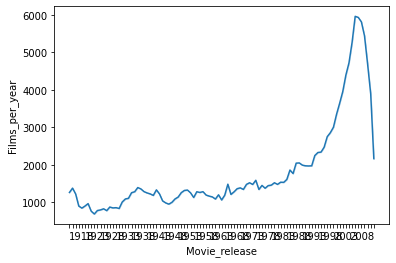

In [16]:
start_date = pd.Timestamp(1913, 1, 1, 0)
end_date = pd.Timestamp(2012, 1, 2, 0)
tick_display_period = 5

df_period_1 = time_genres[(date_index > start_date) & (date_index < end_date)]

timeplot = sns.lineplot(data=df_period_1, x=df_period_1['Movie_release'].astype(str), y="Films_per_year")
i=0
for label in timeplot.xaxis.get_ticklabels():
    i+=1
    if(i%tick_display_period) : 
        label.set_visible(False)
    else : 
        label.set_visible(True)

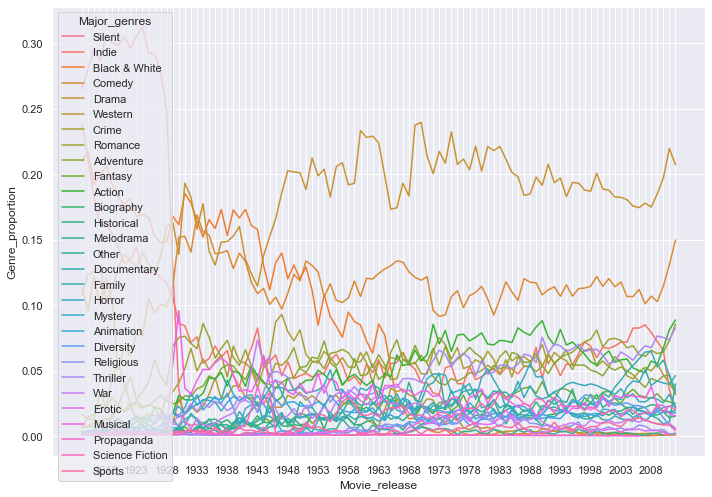

In [17]:
start_date = pd.Timestamp(1913, 1, 1, 0)
end_date = pd.Timestamp(2012, 1, 2, 0)
tick_display_period = 5

df_period_1 = time_genres[(date_index > start_date) & (date_index < end_date)]

sns.set(rc={'figure.figsize':(11.7,8.27)})

timeplot = sns.lineplot(data=df_period_1, x=df_period_1['Movie_release'].astype(str), y="Genre_proportion", hue="Major_genres")

i=0
for label in timeplot.xaxis.get_ticklabels():
    i+=1
    if(i%tick_display_period) : 
        label.set_visible(False)
    else : 
        label.set_visible(True)

plt.show()

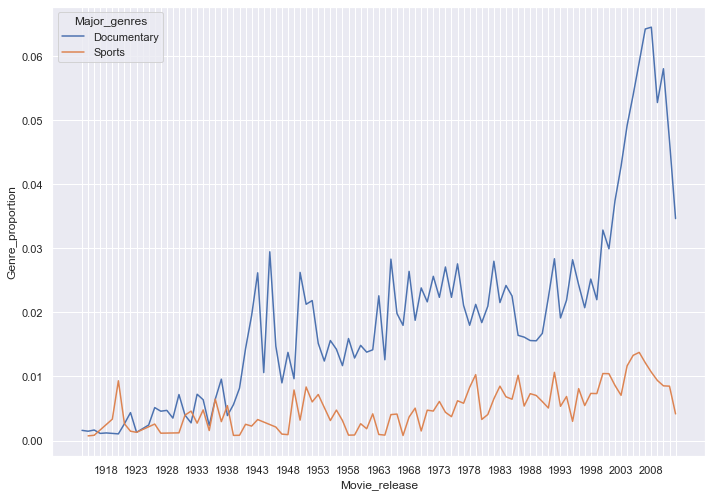

In [27]:
options = ['Sports', 'Documentary']

timeplot = sns.lineplot(data=df_period_1[df_period_1["Major_genres"].isin(options)], x=df_period_1['Movie_release'].astype(str), y="Genre_proportion", hue="Major_genres")

i=0
for label in timeplot.xaxis.get_ticklabels():
    i+=1
    if(i%tick_display_period) : 
        label.set_visible(False)
    else : 
        label.set_visible(True)

plt.show()

In [20]:
occur.head(10)

,Movie_release,Movie_name,Movie_genre
34022,2016-06-08,Jeepers Creepers 4,Thriller
34022,2016-06-08,Jeepers Creepers 4,Horror
30275,2016-03-18,Kung Fu Panda 3,NaN
64862,2016-01-01,Battle Angel,Thriller
64862,2016-01-01,Battle Angel,Science Fiction
64862,2016-01-01,Battle Angel,Action
64862,2016-01-01,Battle Angel,Romance Film
53855,2015-01-01,Total Dhamaal,Comedy film
8307,2015-01-01,"I, Robot 2",Science Fiction
40166,2015-01-01,Knight Rider: The Movie,Crime Fiction


In [21]:
reduced_movies = movies.sort_values("Movie_release", ascending=False).dropna(subset=['Movie_release'])
combined = pd.merge(reduced_movies, summaries, how='inner', on = 'wikipedia_movie_id')
pd.set_option('max_colwidth', 130)
combined[["Movie_release", "Movie_name",'Plot_summaries']].head(30)

,Movie_release,Movie_name,Plot_summaries
0,2014-03-28,Noah,"Subject to divine visions foretelling the end of the world, Noah attempts to tell his people to cease their mistreatment of th..."
1,2014-03-07,Invertigo,"After a NASA space satellite crashes into New York City, apparently under the influence of certain ""dark energy"", a ""reverse-G..."
2,2014-01-01,The Elder,The basic plot of the film involves the recruitment and training of a young hero known only as The Boy by the Council of Elde...
3,2014-01-01,Saving Mr. Banks,"The film centers on the life of Travers, shifting between 1907 with her childhood in Queensland, Australia, the negotiations w..."
4,2013-12-28,Ruby,"The two best friends Karat and Sludge would like to grow, but they cannot do it unless someone or something saves Hera, the pl..."
5,2013-12-01,Getaway,Brent with help of a Kid must get behind the wheel and follow the orders of a mysterious man to save his kidnapped wife.{{c...
6,2013-11-11,The Abandoned State,"The Abandoned State,http://lehtianimation.com/index-1.html chronicles the post-apocalyptic life of a boy and his mother isolat..."
7,2013-10-25,Ender's Game,"Talented pre-teen children, including Andrew ""Ender"" Wiggin, discovered by humanity's military International Fleet , are train..."
8,2013-10-23,The Young and Prodigious Spivet,"A 12-year-old cartography enthusiast in an eccentric family, who travels across country hidden on board a freight train after ..."
9,2013-10-21,Anchorman: The Legend Continues,"Little information about the plot was revealed in the film's teaser trailer.{{cite web}} In a May 2012 interview, he was quote..."


In [22]:
genre_characters = character.dropna(subset=['Actor_gender'])
x=genre_characters.groupby(['Actor_gender'])['Actor_gender'].count()
y=genre_characters['Actor_gender'].count()
genre_percent = ((x/y)*100).round(2)
print(genre_percent)

Actor_gender
F    33.28
M    66.72
Name: Actor_gender, dtype: float64


In [23]:
genre_characters = character.dropna(subset=['Actor_etnicity'])
x=genre_characters.groupby(['Actor_etnicity'])['Actor_etnicity'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
y=x['Count'].sum()
x['percent'] = ((x['Count']/y)*100).round(2)

print(x.head(20))

    Actor_etnicity  Count  percent
428     /m/0dryh9k  16351    15.42
476        /m/0x67  10159     9.58
195       /m/041rx  10121     9.54
125      /m/02w7gg   6165     5.81
141      /m/033tf_   3857     3.64
478       /m/0xnvg   2956     2.79
94       /m/02ctzb   2307     2.18
324      /m/07hwkr   2250     2.12
320      /m/07bch9   2223     2.10
200     /m/044038p   1885     1.78
147      /m/03bkbh   1637     1.54
415       /m/0d7wh   1433     1.35
181      /m/03ts0c   1350     1.27
64       /m/0222qb   1305     1.23
50       /m/01rv7x   1215     1.15
120      /m/02sch9   1155     1.09
242      /m/04mvp8   1146     1.08
169      /m/03lmx1   1028     0.97
288      /m/065b6q    977     0.92
49       /m/01qhm_    949     0.89
